# Homework 2

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM


In [127]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

raw=pd.read_excel('../data/treasury_ts_2015-08-15.xlsx', sheet_name='info')
rawds=pd.read_excel('../data/treasury_ts_2015-08-15.xlsx', sheet_name='database')

bonds=raw.iloc[0,[1,2]]

instruments=rawds.loc[rawds['kytreasno'].isin(bonds)]
instruments=instruments[instruments['caldt']=='2008-11-04']

def get_yield(price, maturity, coupon):
    def bond_price(yield_):
        tp=0
        tt=((maturity*2)-int(maturity*2))/2
        while tt < maturity:
            tp+=(coupon/2)/(((1+(yield_/2))**(2*tt)))
            tt+=0.5
        tp+=(100+(coupon/2))/((1+(yield_/2))**(maturity*2))
        return price-tp
    return opt.root(bond_price, 0.02).x[0]/365.25

# def duration(ytm, c, ttm, freq):
#     my=ytm/freq
#     mc=c/freq
#     mt=ttm*freq
#     return (1/freq)*(((1+my)/my)-((1+my+mt*(mc-my))/((mc*(((1+my)**mt)-1))+my)))

# def duration(ytm, c, ttm, freq):
#     tp=0
#     tt=((ttm*freq)-int(ttm*freq))/freq
#     tpp=0
#     while tt < ttm:
#         tp+=(c/freq)*((1/((1+(ytm/freq))**(ttm*freq)))*((1+(ytm/freq))**tt))
#         tt+=1/freq
#         tpp+=(c/freq)
#     tp+=(100+(c/freq))*((1/((1+(ytm/freq))**(ttm*freq)))*((1+(ytm/freq))**ttm))
#     tpp+=(100+(c/freq))
#     return (tp/tpp)*ttm

def macDuration(ytm, c, ttm, freq):
    tp=0
    tt=((ttm*freq)-int(ttm*freq))/freq
    tpp=0
    while tt < ttm:
        tp+=(c/freq)*(1/((1+(ytm/freq))**(tt*freq)))
        tpp+=tt*(c/freq)*(1/((1+(ytm/freq))**(tt*freq)))
        tt+=1/freq
    tp+=(100+(c/freq))*(1/((1+(ytm/freq))**(ttm*freq)))
    tpp+=ttm*(100+(c/freq))*(1/((1+(ytm/freq))**(ttm*freq)))
    return tpp/tp

tdf=pd.DataFrame()
tdf['instrument']=bonds[::-1]
tdf['coupon']=raw.iloc[7,[1,2]][::-1]
tdf['bid']=instruments['tdbid'].values
tdf['ask']=instruments['tdask'].values
tdf['accrued_interest']=instruments['tdaccint'].values
tdf['dirty_price']=((tdf['bid']+tdf['ask'])/2) + tdf['accrued_interest']
tdf['time-to-maturity']=(pd.to_datetime('2015-08-15')-pd.to_datetime('2008-11-04')).days/365.25
tdf['ytm']=np.vectorize(get_yield)(tdf['dirty_price'], tdf['time-to-maturity'], tdf['coupon'])
tdf['duration']=np.vectorize(macDuration)(tdf['ytm']*365.25, tdf['coupon'], tdf['time-to-maturity'], 2)
tdf['modified_duration']=tdf['duration']/(1+(tdf['ytm']*365.25)/2)
tdf

,instrument,coupon,bid,ask,accrued_interest,dirty_price,time-to-maturity,ytm,duration,modified_duration
1,204047,4.25,105.953125,105.984375,0.935462,106.904212,6.776181,0.000089,5.934895,5.839623
0,204046,10.625,141.859375,141.890625,2.338655,144.213655,6.776181,0.000099,5.228651,5.135989


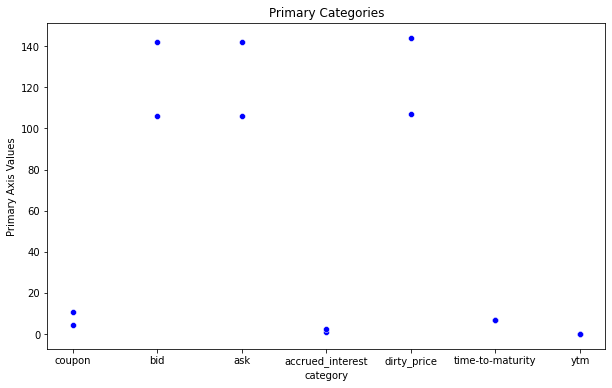

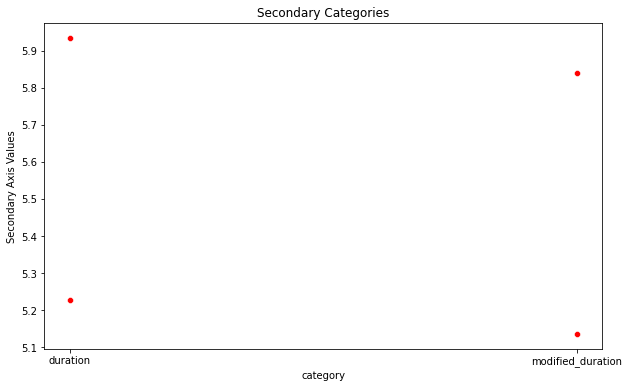

In [128]:
# Melt the DataFrame
tdf_melted = tdf.melt(id_vars='instrument', var_name='category', value_name='value')

import seaborn as sns
import matplotlib.pyplot as plt

# Separate the categories for primary and secondary axes
primary_categories = ['coupon', 'bid', 'ask', 'accrued_interest', 'dirty_price', 'time-to-maturity', 'ytm']
secondary_categories = ['duration', 'modified_duration']

# Filter the melted DataFrame for primary and secondary categories
primary_data = tdf_melted[tdf_melted['category'].isin(primary_categories)]
secondary_data = tdf_melted[tdf_melted['category'].isin(secondary_categories)]

# Plotting Primary Categories
plt.figure(figsize=(10, 6))
sns.scatterplot(data=primary_data, x='category', y='value', color='blue')
plt.ylabel('Primary Axis Values')
plt.title('Primary Categories')
plt.show()

# Plotting Secondary Categories
plt.figure(figsize=(10, 6))
sns.scatterplot(data=secondary_data, x='category', y='value', color='red')
plt.ylabel('Secondary Axis Values')
plt.title('Secondary Categories')
plt.show()



## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [129]:
tdf.set_index('instrument', inplace=True, drop=True)
tdf

/Users/Daniel/miniforge3/envs/RH-r38/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,coupon,bid,ask,accrued_interest,dirty_price,time-to-maturity,ytm,duration,modified_duration
instrument,,,,,,,,,
204047,4.25,105.953125,105.984375,0.935462,106.904212,6.776181,0.000089,5.934895,5.839623
204046,10.625,141.859375,141.890625,2.338655,144.213655,6.776181,0.000099,5.228651,5.135989


In [130]:
n_47=(tdf.loc[204046,'dirty_price']*tdf.loc[204046,'duration'])/(tdf.loc[204047,'duration']*tdf.loc[204047,'dirty_price'])
n_47

1.1884698973980339

In [152]:
print('Bonds, 204046: ', round(50000000/tdf.loc[204046,'dirty_price']))
num_bonds=round(50000000/tdf.loc[204046,'dirty_price'])
print('Notes, 204047: ',round((50000000/tdf.loc[204046,'dirty_price'])*-n_47), 'notes. Equal to :', round((50000000/tdf.loc[204046,'dirty_price'])*-n_47*tdf.loc[204047,'dirty_price']),'USD')
num_notes=round((50000000/tdf.loc[204046,'dirty_price'])*-n_47)

Bonds, 204046:  346708
Notes, 204047:  -412052 notes. Equal to : -44050072 USD


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


In [132]:
def get_price(yield_, maturity, coupon, freq=2):
    tp=0
    tt=((maturity*freq)-int(maturity*freq))/freq
    while tt < maturity:
        tp+=(coupon/freq)/(((1+(yield_/freq))**(freq*tt)))
        tt+=1/freq
    tp+=(100+(coupon/freq))/((1+(yield_/freq))**(maturity*freq))
    return tp

In [133]:
print('Bond, 204046:')
print('Original value: ', 50000000)
tlv=round(get_price((365.25*tdf.loc[204046,'ytm'])-0.00005, tdf.loc[204046,'time-to-maturity'], tdf.loc[204046,'coupon'])*50000000/tdf.loc[204046,'dirty_price'])
print('Value after 5bp ytm decrease: ', tlv)
print('Delta: ', tlv-50000000)
print(' ')
print('Note, 204047:')
tov=(50000000/tdf.loc[204046,'dirty_price'])*-n_47*tdf.loc[204047,'dirty_price']
print('Original value: ', round(tov))
tsv=round(get_price((365.25*tdf.loc[204047,'ytm'])+0.00005, tdf.loc[204047,'time-to-maturity'], tdf.loc[204047,'coupon'])*tov/tdf.loc[204047,'dirty_price'])
print('Value after 5bp ytm increase: ', tsv)
print('Delta: ', tsv-round(tov))

print(' ')
print('Total portfolio:')
print('Original value: ', round(50000000+tov))
print('Value after 5bp ytm increase: ', round(tlv+tsv))
print('Delta: ', round(tlv+tsv)-round(50000000+tov))



Bond, 204046:
Original value:  50000000
Value after 5bp ytm decrease:  50012842
Delta:  12842
 
Note, 204047:
Original value:  -44050072
Value after 5bp ytm increase:  -44037212
Delta:  12860
 
Total portfolio:
Original value:  5949928
Value after 5bp ytm increase:  5975630
Delta:  25702


In [134]:
print('For full convergence: ', 34*(round(tlv+tsv)-round(50000000+tov)))

For full convergence:  873868




## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?


In [125]:
print('2008-11-25')

instruments=rawds.loc[rawds['kytreasno'].isin(bonds)]
instruments=instruments[instruments['caldt']=='2008-11-25']

tdf=pd.DataFrame()
tdf['instrument']=bonds[::-1]
tdf['coupon']=raw.iloc[7,[1,2]][::-1]
tdf['bid']=instruments['tdbid'].values
tdf['ask']=instruments['tdask'].values
tdf['accrued_interest']=instruments['tdaccint'].values
tdf['dirty_price']=((tdf['bid']+tdf['ask'])/2) + tdf['accrued_interest']
tdf['time-to-maturity']=(pd.to_datetime('2015-08-25')-pd.to_datetime('2008-11-04')).days/365.25
tdf['ytm']=np.vectorize(get_yield)(tdf['dirty_price'], tdf['time-to-maturity'], tdf['coupon'])
tdf['duration']=np.vectorize(macDuration)(tdf['ytm']*365.25, tdf['coupon'], tdf['time-to-maturity'], 2)
tdf['modified_duration']=tdf['duration']/(1+(tdf['ytm']*365.25)/2)

tdf.set_index('instrument', inplace=True, drop=True)

n_47=(tdf.loc[204046,'dirty_price']*tdf.loc[204046,'duration'])/(tdf.loc[204047,'duration']*tdf.loc[204047,'dirty_price'])

print('Bond, 204046:')
print('Original value: ', 50000000)
tlv=round(get_price((365.25*tdf.loc[204046,'ytm'])-0.00005, tdf.loc[204046,'time-to-maturity'], tdf.loc[204046,'coupon'])*50000000/tdf.loc[204046,'dirty_price'])
print('Value after 5bp ytm decrease: ', tlv)
print('Delta: ', tlv-50000000)
print(' ')
print('Note, 204047:')
tov=(50000000/tdf.loc[204046,'dirty_price'])*-n_47*tdf.loc[204047,'dirty_price']
print('Original value: ', round(tov))
tsv=round(get_price((365.25*tdf.loc[204047,'ytm'])+0.00005, tdf.loc[204047,'time-to-maturity'], tdf.loc[204047,'coupon'])*tov/tdf.loc[204047,'dirty_price'])
print('Value after 5bp ytm increase: ', tsv)
print('Delta: ', tsv-round(tov))

print(' ')
print('Total portfolio:')
print('Original value: ', round(50000000+tov))
print('Value after 5bp ytm increase: ', round(tlv+tsv))
print('Delta: ', round(tlv+tsv)-round(50000000+tov))

print('\nFor full convergence: ', 34*(round(tlv+tsv)-round(50000000+tov)),'\n')

tdf

2008-11-25
Bond, 204046:
Original value:  50000000
Value after 5bp ytm decrease:  50013020
Delta:  13020
 
Note, 204047:
Original value:  -44136401
Value after 5bp ytm increase:  -44123352
Delta:  13049
 
Total portfolio:
Original value:  5863599
Value after 5bp ytm increase:  5889668
Delta:  26069

For full convergence:  886346 



/Users/Daniel/miniforge3/envs/RH-r38/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,coupon,bid,ask,accrued_interest,dirty_price,time-to-maturity,ytm,duration,modified_duration
instrument,,,,,,,,,
204047,4.25,110.796875,110.828125,1.177989,111.990489,6.803559,0.000067,5.986860,5.914150
204046,10.625,145.859375,145.890625,2.944973,148.819973,6.803559,0.000082,5.284769,5.207103


In [126]:
print('2008-12-16')

instruments=rawds.loc[rawds['kytreasno'].isin(bonds)]
instruments=instruments[instruments['caldt']=='2008-12-16']

tdf=pd.DataFrame()
tdf['instrument']=bonds[::-1]
tdf['coupon']=raw.iloc[7,[1,2]][::-1]
tdf['bid']=instruments['tdbid'].values
tdf['ask']=instruments['tdask'].values
tdf['accrued_interest']=instruments['tdaccint'].values
tdf['dirty_price']=((tdf['bid']+tdf['ask'])/2) + tdf['accrued_interest']
tdf['time-to-maturity']=(pd.to_datetime('2015-08-25')-pd.to_datetime('2008-12-16')).days/365.25
tdf['ytm']=np.vectorize(get_yield)(tdf['dirty_price'], tdf['time-to-maturity'], tdf['coupon'])
tdf['duration']=np.vectorize(macDuration)(tdf['ytm']*365.25, tdf['coupon'], tdf['time-to-maturity'], 2)
tdf['modified_duration']=tdf['duration']/(1+(tdf['ytm']*365.25)/2)

tdf.set_index('instrument', inplace=True, drop=True)

n_47=(tdf.loc[204046,'dirty_price']*tdf.loc[204046,'duration'])/(tdf.loc[204047,'duration']*tdf.loc[204047,'dirty_price'])

print('Bond, 204046:')
print('Original value: ', 50000000)
tlv=round(get_price((365.25*tdf.loc[204046,'ytm'])-0.00005, tdf.loc[204046,'time-to-maturity'], tdf.loc[204046,'coupon'])*50000000/tdf.loc[204046,'dirty_price'])
print('Value after 5bp ytm decrease: ', tlv)
print('Delta: ', tlv-50000000)
print(' ')
print('Note, 204047:')
tov=(50000000/tdf.loc[204046,'dirty_price'])*-n_47*tdf.loc[204047,'dirty_price']
print('Original value: ', round(tov))
tsv=round(get_price((365.25*tdf.loc[204047,'ytm'])+0.00005, tdf.loc[204047,'time-to-maturity'], tdf.loc[204047,'coupon'])*tov/tdf.loc[204047,'dirty_price'])
print('Value after 5bp ytm increase: ', tsv)
print('Delta: ', tsv-round(tov))

print(' ')
print('Total portfolio:')
print('Original value: ', round(50000000+tov))
print('Value after 5bp ytm increase: ', round(tlv+tsv))
print('Delta: ', round(tlv+tsv)-round(50000000+tov))

print('\nFor full convergence: ', 34*(round(tlv+tsv)-round(50000000+tov)),'\n')


2008-12-16
Bond, 204046:
Original value:  50000000
Value after 5bp ytm decrease:  50012875
Delta:  12875
 
Note, 204047:
Original value:  -44106692
Value after 5bp ytm increase:  -44093775
Delta:  12917
 
Total portfolio:
Original value:  5893308
Value after 5bp ytm increase:  5919100
Delta:  25792

For full convergence:  876928 



/Users/Daniel/miniforge3/envs/RH-r38/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)



## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [156]:
dates=['2008-11-04','2008-11-25','2008-12-16','2009-01-27','2009-03-24','2009-06-16']
dirty_prices=pd.DataFrame()
for i in dates:
    dirty_prices.loc[i,'204046']=((rawds.loc[(rawds['kytreasno']==204046) & (rawds['caldt']==i),'tdbid'].values[0]+\
                                   rawds.loc[(rawds['kytreasno']==204046) & (rawds['caldt']==i),'tdask'].values[0])/2)+\
                                    rawds.loc[(rawds['kytreasno']==204046) & (rawds['caldt']==i),'tdaccint'].values[0]
    dirty_prices.loc[i,'204047']=(rawds.loc[(rawds['kytreasno']==204047) & (rawds['caldt']==i),'tdbid'].values[0]+\
                                  rawds.loc[(rawds['kytreasno']==204047) & (rawds['caldt']==i),'tdask'].values[0])/2+\
                                    rawds.loc[(rawds['kytreasno']==204047) & (rawds['caldt']==i),'tdaccint'].values[0]
dirty_prices

,204046,204047
2008-11-04,144.213655,106.904212
2008-11-25,148.819973,111.990489
2008-12-16,155.488791,118.936141
2009-01-27,155.232677,116.124321
2009-03-24,150.968793,113.910955
2009-06-16,146.301450,108.092455


In [158]:
dirty_prices['46']=num_bonds
dirty_prices['47']=num_notes
dirty_prices['PnL_Long']=((dirty_prices['204046']-dirty_prices.iloc[0,0])*dirty_prices['46'])
dirty_prices['PnL_Short']=((dirty_prices['204047']-dirty_prices.iloc[0,1])*dirty_prices['47'])
dirty_prices['PnL']=dirty_prices['PnL_Long']+dirty_prices['PnL_Short']
dirty_prices

,204046,204047,46,47,PnL_Long,PnL_Short,PnL
2008-11-04,144.213655,106.904212,346708,-412052,0.000000e+00,-0.000000e+00,0.000000e+00
2008-11-25,148.819973,111.990489,346708,-412052,1.597047e+06,-2.095811e+06,-4.987634e+05
2008-12-16,155.488791,118.936141,346708,-412052,3.909180e+06,-4.957781e+06,-1.048601e+06
2009-01-27,155.232677,116.124321,346708,-412052,3.820383e+06,-3.799164e+06,2.121876e+04
2009-03-24,150.968793,113.910955,346708,-412052,2.342060e+06,-2.887142e+06,-5.450819e+05
2009-06-16,146.301450,108.092455,346708,-412052,7.238554e+05,-4.896180e+05,2.342374e+05


***

# 2 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207404).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`


In [159]:
tsdata = pd.read_excel('../data/treasury_ts_issue_duration_(207392, 207391, 207404).xlsx',sheet_name='ts')

tsdata.columns = tsdata.columns.str.upper()

px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()


## 2.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)


In [171]:
-(10000/px.iloc[-1,0])*duration.iloc[-1,0]*px.iloc[-1,0]/(duration.iloc[-1,1]*px.iloc[-1,1])

-47.58054231192276

## 2.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

In [194]:
df=pd.DataFrame()
df['207391_price']=px.iloc[:,0]
df['207392_price']=px.iloc[:,1]
df['207391_duration']=duration.iloc[:,0]
df['207392_duration']=duration.iloc[:,1]
df['207391_units']=10000/df['207391_price']
df['207392_units']=-(10000/df['207391_price'])*df['207391_duration']*df['207391_price']/(df['207392_duration']*df['207392_price'])
df['PnL_Price_Movement']=0
df['PnL_Position_Reset']=0
indeces=df.index
for i in range(1,len(df)):
    df.loc[indeces[i],'PnL_Price_Movement']=(df.loc[indeces[i-1],'207391_units']*(df.loc[indeces[i],'207391_price']-df.loc[indeces[i-1],'207391_price'])+\
                                df.loc[indeces[i-1],'207392_units']*(df.loc[indeces[i],'207392_price']-df.loc[indeces[i-1],'207392_price']))
    df.loc[indeces[i],'PnL_Position_Reset']=((df.loc[indeces[i-1],'207391_units']-df.loc[indeces[i],'207391_units'])*df.loc[indeces[i],'207391_price']+\
                                (df.loc[indeces[i-1],'207392_units']-df.loc[indeces[i],'207392_units'])*df.loc[indeces[i],'207392_price'])
df['PnL']=df['PnL_Price_Movement']+df['PnL_Position_Reset']

df


,207391_price,207392_price,207391_duration,207392_duration,207391_units,207392_units,PnL_Price_Movement,PnL_Position_Reset,PnL
CALDT,,,,,,,,,
2019-08-29,101.203125,106.468750,3374.474064,8118.130082,98.811178,-39.041629,0.000000,0.000000,0.000000
2019-08-30,101.187500,106.500000,3373.448656,8117.621930,98.826436,-39.020756,-2.763976,-3.766959,-6.530934
2019-09-03,101.585938,106.726562,3370.108760,8117.161185,98.438822,-38.901579,30.535518,26.656792,57.192311
2019-09-04,101.500000,106.335938,3368.967737,8110.102167,98.522167,-39.065237,6.736343,8.943174,15.679517
2019-09-05,100.632812,104.500000,3366.527139,8080.114474,99.371167,-39.870191,-13.715859,-1.319494,-15.035352
...,...,...,...,...,...,...,...,...,...
2023-11-24,85.859375,63.187500,1986.460985,6425.508899,116.469518,-48.926183,6.299249,12.677449,18.976699
2023-11-27,86.203125,63.937500,1983.732835,6443.212765,116.005075,-48.153189,3.341759,-9.386892,-6.045133
2023-11-28,86.632812,64.343750,1983.062432,6453.306561,115.429705,-47.758175,30.283698,24.429217,54.712915


<AxesSubplot:xlabel='CALDT'>

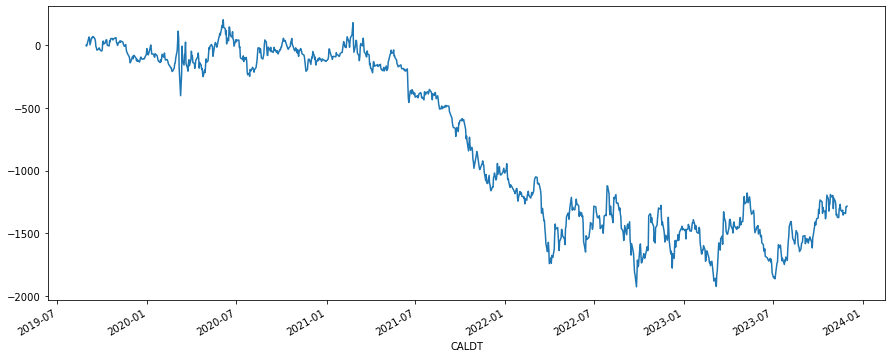

In [198]:
series=df['PnL']
df['PnL'].cumsum().plot(figsize=(15,6))

In [202]:
print('Daily PnL Statistics:')
print('   Mean (USD): ', round(series.mean(),2))
print('   Standard Deviation (USD): ', round(series.std(),2))
print('   Skewness: ', round(series.skew(),2))
print('   Kurtosis: ', round(series.kurtosis(),2))
print('   Minimum (USD): ', round(series.min(),2))
print('   Maximum (USD): ', round(series.max(),2))

Daily PnL Statistics:
   Mean (USD):  -1.2
   Standard Deviation (USD):  45.59
   Skewness:  0.19
   Kurtosis:  3.5
   Minimum (USD):  -234.6
   Maximum (USD):  260.2


***

# 3 Calculating Duration Via Individual Cashflows

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

Use the data file `../data/treasury_quotes_2023-07-26.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

## 3.1 
Set up the cashflow matrix. 


## 3.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*

## 3.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)


## 3.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

## 3.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

## 3.6

Re-do the duration and convexity calculations using an extracted discount curve instead of a discount curve based on a constant (arbitrary) spot rate. 

***

# 4 Other Interest-Rate Risks

## *Optional*

***No need to submit this problem, but if we discuss it, then you are expected to know it.***

## 4.1 Other Yield Curve Movements

Use the yield curve time-series data in `'../data/yields.xlsx` to calculate the time-series of the **level**, **slope**, and curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the mean and volatility of each factor.

Report the correlation matrix of the factors.

## 4.2 Factor Duration

Calculate the factor duration of the treasuries from `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

Run a multivariate regression of the bond prices on all three factors constructed above from the yield factors: level, slope, and curvature. 

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

$\begin{align}
\frac{dP}{P} = \beta_1 dz_1 + \beta_2 dz_2 + \beta_3 dz_3 + \epsilon
\end{align}$

Report the betas for each of these factors, for each of the bond prices.

***